In [8]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import flax.linen as nn
from typing import Sequence

# Generate synthetic GBM data
def generate_gbm_data(n, mu, sigma, dt, S0):
    S = [S0]
    for i in range(n):
        S.append(S[-1] * jnp.exp((mu - 0.5 * sigma ** 2) * dt + sigma * jnp.sqrt(dt) * jax.random.normal(jax.random.PRNGKey(i), ())))
    return jnp.array(S)

# Parameters
n = 1000
mu_true = 0.05
sigma_true = 0.2
dt = 1 / 252
S0 = 100

# Generate data
S = generate_gbm_data(n, mu_true, sigma_true, dt, S0)
log_returns = jnp.log(S[1:] / S[:-1]).reshape(-1, 1)  # Reshape to (n, 1)

# Define the MLP for the normalizing flow
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.Dense(feat)(x)
            x = nn.relu(x)
        x = nn.Dense(self.features[-1])(x)
        return x

# Define a Normalizing Flow model with Equinox
class NormalizingFlow(eqx.Module):
    nn: eqx.Module

    def __call__(self, x, params):
        return self.nn.apply(params, x)

# Initialize the model
key = jax.random.PRNGKey(0)
mlp = MLP([50, 50, 1])
params = mlp.init(key, log_returns)

model = NormalizingFlow(mlp)

# Define the loss function
def loss_fn(params, model, x):
    transformed_data = model(x, params)
    return -jnp.mean(jax.scipy.stats.norm.logpdf(transformed_data))

# Define the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

# Training step
@jax.jit
def train_step(params, opt_state, model, x):
    loss, grads = jax.value_and_grad(loss_fn)(params, model, x)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Training loop
num_steps = 10000
for step in range(num_steps):
    params, opt_state, loss = train_step(params, opt_state, model, log_returns)
    if step % 1000 == 0:
        print(f"Step {step} : loss = {loss}")

# Extract parameters
transformed_data = model(log_returns, params)
est_mean = jnp.mean(transformed_data)
est_var = jnp.var(transformed_data)
est_sigma = jnp.sqrt(est_var)
est_mu = est_mean + 0.5 * est_sigma ** 2

print(f"Estimated mu: {est_mu}, Estimated sigma: {est_sigma}")


TypeError: Cannot interpret value of type <class '__main__.MLP'> as an abstract array; it does not have a dtype attribute

In [24]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

class AffineFlow(eqx.Module):
    scale: jnp.ndarray
    shift: jnp.ndarray

    def __init__(self, key):
        self.scale = jnp.exp(jax.random.normal(key, ()))
        self.shift = jax.random.normal(key, ())

    def forward(self, x):
        y = self.scale * x + self.shift
        log_det = jnp.log(jnp.abs(self.scale))
        return y, log_det

    def inverse(self, y):
        x = (y - self.shift) / self.scale
        log_det = -jnp.log(jnp.abs(self.scale))
        return x, log_det

def asymmetric_laplace(key, m, lambda_, kappa, size):
    u = jax.random.uniform(key, (size,))
    return jnp.where(
        u < kappa / (kappa + 1),
        m + lambda_ / kappa * jnp.log(u * (kappa + 1) / kappa),
        m - lambda_ * jnp.log((1 - u) * (kappa + 1))
    )

@eqx.filter_value_and_grad
def loss_fn(model, data):
    z, log_det = model.inverse(data)
    log_prob = jax.scipy.stats.norm.logpdf(z) + log_det
    return -jnp.mean(log_prob)

@eqx.filter_jit
def make_step(model, opt_state, data):
    loss, grads = loss_fn(model, data)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

# Generate data
key = jax.random.PRNGKey(0)
data = asymmetric_laplace(key, m=0.5, lambda_=1, kappa=0.5, size=1000)

# Initialize model and optimizer
model = AffineFlow(jax.random.PRNGKey(1))
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Training loop
for i in range(20000):
    loss, model, opt_state = make_step(model, opt_state, data)
    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss}")

# Generate samples from the learned distribution
z = jax.random.normal(jax.random.PRNGKey(2), (10000,))
samples, _ = model.forward(z)

# You can now compare the histogram of 'samples' with the histogram of 'data'
# to see how well the model has learned the distribution.

Step 0, Loss: 37.16727066040039
Step 100, Loss: 21.84295082092285
Step 200, Loss: 15.901144981384277
Step 300, Loss: 12.681634902954102
Step 400, Loss: 10.636693954467773
Step 500, Loss: 9.213932037353516
Step 600, Loss: 8.163313865661621
Step 700, Loss: 7.3541741371154785
Step 800, Loss: 6.711184024810791
Step 900, Loss: 6.187700271606445
Step 1000, Loss: 5.753219127655029
Step 1100, Loss: 5.386903762817383
Step 1200, Loss: 5.074021816253662
Step 1300, Loss: 4.803837299346924
Step 1400, Loss: 4.56833553314209
Step 1500, Loss: 4.361410140991211
Step 1600, Loss: 4.1783223152160645
Step 1700, Loss: 4.015331268310547
Step 1800, Loss: 3.8694469928741455
Step 1900, Loss: 3.738248109817505
Step 2000, Loss: 3.619753837585449
Step 2100, Loss: 3.5123205184936523
Step 2200, Loss: 3.4145829677581787
Step 2300, Loss: 3.3253862857818604
Step 2400, Loss: 3.2437551021575928
Step 2500, Loss: 3.1688551902770996
Step 2600, Loss: 3.0999696254730225
Step 2700, Loss: 3.0364787578582764
Step 2800, Loss: 2.9

In [25]:
import matplotlib.pyplot as plt
from scipy import stats

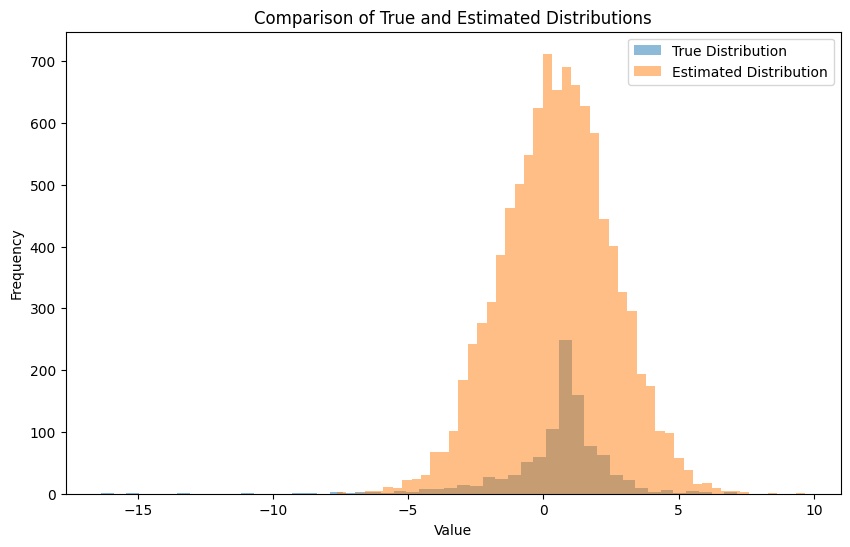

Kolmogorov-Smirnov test results:
KS statistic: 0.1673
p-value: 1.091109821871199e-22


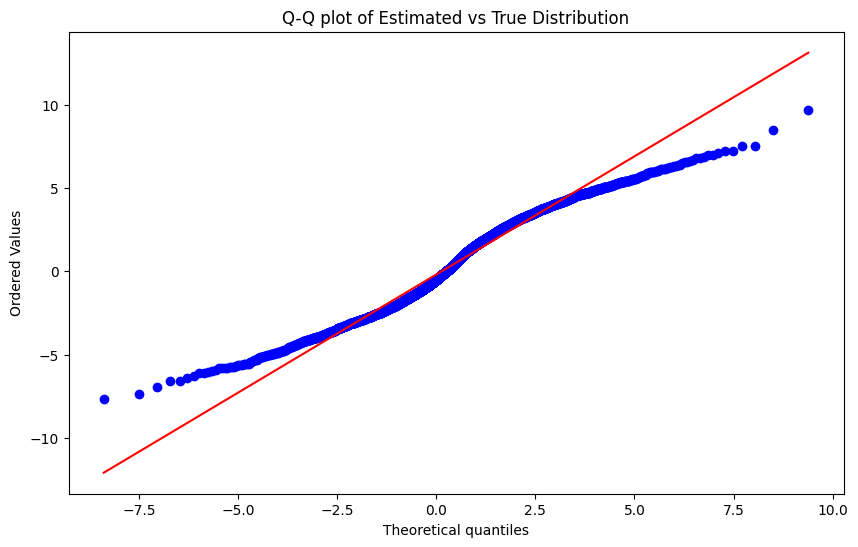

True distribution - Mean: 0.4995, Variance: 4.1734
Estimated distribution - Mean: 0.5126, Variance: 4.1526


In [26]:
# Convert to numpy for plotting and statistical tests
true_data_np = jnp.array(data)
estimated_samples_np = jnp.array(samples)

# Visual comparison: Histogram
plt.figure(figsize=(10, 6))
plt.hist(true_data_np, bins=50, alpha=0.5, label='True Distribution')
plt.hist(estimated_samples_np, bins=50, alpha=0.5, label='Estimated Distribution')
plt.legend()
plt.title('Comparison of True and Estimated Distributions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Statistical comparison: Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(true_data_np, estimated_samples_np)

print(f"Kolmogorov-Smirnov test results:")
print(f"KS statistic: {ks_statistic}")
print(f"p-value: {p_value}")

# Quantile-Quantile plot
plt.figure(figsize=(10, 6))
stats.probplot(estimated_samples_np, dist=stats.laplace, sparams=(0.5, 1), plot=plt)
plt.title("Q-Q plot of Estimated vs True Distribution")
plt.show()

# Compare moments
true_mean, true_var = jnp.mean(true_data_np), jnp.var(true_data_np)
est_mean, est_var = jnp.mean(estimated_samples_np), jnp.var(estimated_samples_np)

print(f"True distribution - Mean: {true_mean:.4f}, Variance: {true_var:.4f}")
print(f"Estimated distribution - Mean: {est_mean:.4f}, Variance: {est_var:.4f}")

In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
class PlanarFlow(eqx.Module):
    w: jnp.ndarray
    u: jnp.ndarray
    b: jnp.ndarray

    def __init__(self, dim, key):
        wkey, ukey, bkey = jax.random.split(key, 3)
        self.w = jax.random.normal(wkey, (dim,))
        self.u = jax.random.normal(ukey, (dim,))
        self.b = jax.random.normal(bkey, ())

    def forward(self, x):
        wx = jnp.dot(self.w, x)
        u_wx = jnp.dot(self.u, self.w)
        activation = jnp.tanh(wx + self.b)
        z = x + self.u * activation
        psi = (1 - activation**2) * self.w
        log_det = jnp.log(jnp.abs(1 + jnp.dot(self.u, psi)))
        return z, log_det

    def inverse(self, z):
        # Note: Planar flows don't have a closed-form inverse
        # This is an approximate inverse using fixed-point iteration
        x = z
        for _ in range(100):  # You may need to adjust the number of iterations
            wx = jnp.dot(self.w, x)
            activation = jnp.tanh(wx + self.b)
            x = z - self.u * activation
        log_det = -jnp.log(jnp.abs(1 + jnp.dot(self.u, (1 - activation**2) * self.w)))
        return x, log_det

In [3]:
class NormalizingFlow(eqx.Module):
    layers: list

    def __init__(self, dim, num_layers, key):
        keys = jax.random.split(key, num_layers)
        self.layers = [PlanarFlow(dim, k) for k in keys]

    def forward(self, x):
        log_det_sum = jnp.zeros(x.shape[0])
        for layer in self.layers:
            x, log_det = jax.vmap(layer.forward)(x)
            log_det_sum += log_det
        return x, log_det_sum

    def inverse(self, z):
        log_det_sum = jnp.zeros(z.shape[0])
        for layer in reversed(self.layers):
            z, log_det = jax.vmap(layer.inverse)(z)
            log_det_sum += log_det
        return z, log_det_sum

In [4]:
def asymmetric_laplace(key, m, lambda_, kappa, size):
    u = jax.random.uniform(key, (size,))
    return jnp.where(
        u < kappa / (kappa + 1),
        m + lambda_ / kappa * jnp.log(u * (kappa + 1) / kappa),
        m - lambda_ * jnp.log((1 - u) * (kappa + 1))
    )

In [5]:
@eqx.filter_value_and_grad
def loss_fn(model, data):
    z, log_det = model.inverse(data)
    log_prob = jax.scipy.stats.norm.logpdf(z) + log_det
    return -jnp.mean(log_prob)

In [6]:
@eqx.filter_jit
def make_step(model, opt_state, data):
    loss, grads = loss_fn(model, data)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [8]:
# Generate data
key = jax.random.PRNGKey(0)
true_data = asymmetric_laplace(key, m=0.5, lambda_=1, kappa=0.5, size=100)

In [9]:
# Initialize model and optimizer
model = NormalizingFlow(dim=1, num_layers=5, key=jax.random.PRNGKey(1))
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

In [10]:
# Training loop
for i in range(5):
    loss, model, opt_state = make_step(model, opt_state, true_data)
    if i % 1 == 0:
        print(f"Step {i}, Loss: {loss}")

In [1]:






print('I am about to start')



# Generate samples from the learned distribution
z = jax.random.normal(jax.random.PRNGKey(2), (10000,))
estimated_samples, _ = model.forward(z)

# Convert to numpy for plotting and statistical tests
true_data_np = jnp.array(true_data)
estimated_samples_np = jnp.array(estimated_samples)

# Visual comparison: Histogram
plt.figure(figsize=(10, 6))
plt.hist(true_data_np, bins=50, alpha=0.5, label='True Distribution', density=True)
plt.hist(estimated_samples_np, bins=50, alpha=0.5, label='Estimated Distribution', density=True)
plt.legend()
plt.title('Comparison of True and Estimated Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Statistical comparison: Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(true_data_np, estimated_samples_np)

print(f"Kolmogorov-Smirnov test results:")
print(f"KS statistic: {ks_statistic}")
print(f"p-value: {p_value}")

# Quantile-Quantile plot
plt.figure(figsize=(10, 6))
stats.probplot(estimated_samples_np, dist=stats.laplace, sparams=(0.5, 1), plot=plt)
plt.title("Q-Q plot of Estimated vs True Distribution")
plt.show()

# Compare moments
true_mean, true_var = jnp.mean(true_data_np), jnp.var(true_data_np)
est_mean, est_var = jnp.mean(estimated_samples_np), jnp.var(estimated_samples_np)

print(f"True distribution - Mean: {true_mean:.4f}, Variance: {true_var:.4f}")
print(f"Estimated distribution - Mean: {est_mean:.4f}, Variance: {est_var:.4f}")

I am about to start


Epoch 0, Average Loss: 2.5708956718444824
Epoch 10, Average Loss: 2.559276819229126
Epoch 20, Average Loss: 2.547852039337158
Epoch 30, Average Loss: 2.5366711616516113
Epoch 40, Average Loss: 2.52577543258667
Epoch 50, Average Loss: 2.515228271484375
Epoch 60, Average Loss: 2.5051863193511963
Epoch 70, Average Loss: 2.4960358142852783
Epoch 80, Average Loss: 2.4887003898620605
Epoch 90, Average Loss: 2.484220504760742
Epoch 100, Average Loss: 2.480783462524414
Epoch 110, Average Loss: 2.477595806121826
Epoch 120, Average Loss: 2.4748470783233643
Epoch 130, Average Loss: 2.4722790718078613
Epoch 140, Average Loss: 2.469883918762207
Epoch 150, Average Loss: 2.4676103591918945
Epoch 160, Average Loss: 2.4654319286346436
Epoch 170, Average Loss: 2.4633238315582275
Epoch 180, Average Loss: 2.46126651763916
Epoch 190, Average Loss: 2.459240436553955
Epoch 200, Average Loss: 2.4572315216064453
Epoch 210, Average Loss: 2.4552228450775146
Epoch 220, Average Loss: 2.4532008171081543
Epoch 230, 

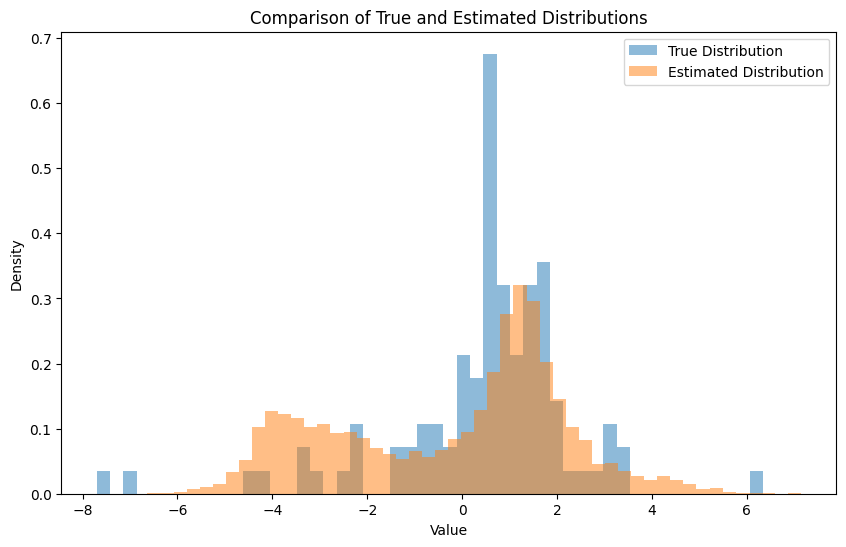

Kolmogorov-Smirnov test results:
KS statistic: 0.2206
p-value: 0.00010379342619321928


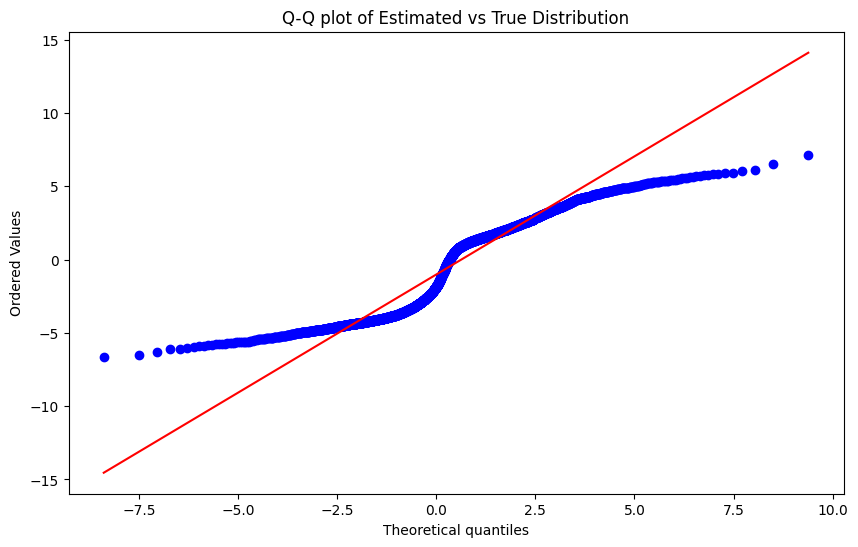

True distribution - Mean: 0.4379, Variance: 3.9042
Estimated distribution - Mean: -0.2126, Variance: 5.9574


In [18]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from scipy import stats

class PlanarFlow(eqx.Module):
    w: jnp.ndarray
    u: jnp.ndarray
    b: jnp.ndarray

    def __init__(self, dim, key):
        wkey, ukey, bkey = jax.random.split(key, 3)
        self.w = jax.random.normal(wkey, (dim,))
        self.u = jax.random.normal(ukey, (dim,))
        self.b = jax.random.normal(bkey, ())

    def forward(self, x):
        wx = jnp.dot(x, self.w)
        activation = jnp.tanh(wx + self.b)
        z = x + jnp.outer(activation, self.u)
        psi = (1 - activation**2)[:, None] * self.w
        log_det = jnp.log(jnp.abs(1 + jnp.dot(psi, self.u)))
        return z, log_det

    def inverse(self, z):
        def single_inverse(zi):
            xi = zi
            for _ in range(20):
                wx = jnp.dot(xi, self.w)
                activation = jnp.tanh(wx + self.b)
                xi = zi - activation * self.u
            log_det = -jnp.log(jnp.abs(1 + jnp.dot((1 - activation**2) * self.w, self.u)))
            return xi, log_det
        return jax.vmap(single_inverse)(z)

class NormalizingFlow(eqx.Module):
    layers: list

    def __init__(self, dim, num_layers, key):
        keys = jax.random.split(key, num_layers)
        self.layers = [PlanarFlow(dim, k) for k in keys]

    def forward(self, x):
        log_det_sum = jnp.zeros(x.shape[0])
        for layer in self.layers:
            x, log_det = layer.forward(x)
            log_det_sum += log_det
        return x, log_det_sum

    def inverse(self, z):
        log_det_sum = jnp.zeros(z.shape[0])
        for layer in reversed(self.layers):
            z, log_det = layer.inverse(z)
            log_det_sum += log_det
        return z, log_det_sum

def asymmetric_laplace(key, m, lambda_, kappa, size):
    u = jax.random.uniform(key, (size,))
    return jnp.where(
        u < kappa / (kappa + 1),
        m + lambda_ / kappa * jnp.log(u * (kappa + 1) / kappa),
        m - lambda_ * jnp.log((1 - u) * (kappa + 1))
    )

@eqx.filter_value_and_grad
def loss_fn(model, data):
    z, log_det = model.inverse(data)
    log_prob = jax.scipy.stats.norm.logpdf(z) + log_det
    return -jnp.mean(log_prob)

@eqx.filter_jit
def make_step(model, opt_state, data):
    loss, grads = loss_fn(model, data)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

# Generate data
key = jax.random.PRNGKey(1)
true_data = asymmetric_laplace(key, m=0.5, lambda_=1, kappa=0.5, size=100)

# Initialize model and optimizer
model = NormalizingFlow(dim=1, num_layers=3, key=jax.random.PRNGKey(1))
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Training loop with mini-batches
batch_size = 64
num_batches = len(true_data) // batch_size
for epoch in range(5000):
    epoch_loss = 0.0
    for i in range(num_batches):
        batch = true_data[i*batch_size:(i+1)*batch_size]
        batch = batch.reshape(-1, 1)  # Reshape to (batch_size, 1)
        loss, model, opt_state = make_step(model, opt_state, batch)
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Average Loss: {epoch_loss / num_batches}")

# Generate samples from the learned distribution
z = jax.random.normal(jax.random.PRNGKey(2), (10000, 1))
estimated_samples, _ = model.forward(z)

# Convert to numpy for plotting and statistical tests
true_data_np = jnp.array(true_data)
estimated_samples_np = jnp.array(estimated_samples).flatten()

# Visual comparison: Histogram
plt.figure(figsize=(10, 6))
plt.hist(true_data_np, bins=50, alpha=0.5, label='True Distribution', density=True)
plt.hist(estimated_samples_np, bins=50, alpha=0.5, label='Estimated Distribution', density=True)
plt.legend()
plt.title('Comparison of True and Estimated Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Statistical comparison: Kolmogorov-Smirnov test
ks_statistic, p_value = stats.ks_2samp(true_data_np, estimated_samples_np)

print(f"Kolmogorov-Smirnov test results:")
print(f"KS statistic: {ks_statistic}")
print(f"p-value: {p_value}")

# Quantile-Quantile plot
plt.figure(figsize=(10, 6))
stats.probplot(estimated_samples_np, dist=stats.laplace, sparams=(0.5, 1), plot=plt)
plt.title("Q-Q plot of Estimated vs True Distribution")
plt.show()

# Compare moments
true_mean, true_var = jnp.mean(true_data_np), jnp.var(true_data_np)
est_mean, est_var = jnp.mean(estimated_samples_np), jnp.var(estimated_samples_np)

print(f"True distribution - Mean: {true_mean:.4f}, Variance: {true_var:.4f}")
print(f"Estimated distribution - Mean: {est_mean:.4f}, Variance: {est_var:.4f}")

In [221]:
jnp.pi

3.141592653589793

In [19]:
# Conditional

In [207]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from scipy import stats

class ConditionalPlanarFlow(eqx.Module):
    w: jnp.ndarray
    u: jnp.ndarray
    b: jnp.ndarray
    cond_net: eqx.nn.MLP

    def __init__(self, dim, cond_dim, hidden_size, key):
        wkey, ukey, bkey, netkey = jax.random.split(key, 4)
        self.w = jax.random.normal(wkey, (dim,))
        self.u = jax.random.normal(ukey, (dim,))
        self.b = jax.random.normal(bkey, ())
        self.cond_net = eqx.nn.MLP(
            in_size=cond_dim,
            out_size=dim + dim + 1,  # w, u, and b
            width_size=hidden_size,
            depth=2,
            key=netkey
        )

    def get_params(self, cond):
        params = jax.vmap(self.cond_net)(cond)
        w, u, b = jnp.split(params, [self.w.shape[0], 2*self.w.shape[0]], axis=1)
        return w + self.w, u + self.u, b + self.b

    def forward(self, x, cond):
        w, u, b = self.get_params(cond)
        wx = jnp.sum(x * w, axis=1, keepdims=True)
        activation = jax.nn.tanh(wx + b)
        z = x + activation * u
        psi = (1 - activation**2) * w
        log_det = jnp.log(jnp.abs(1 + jnp.sum(psi * u, axis=1, keepdims=True)))
        return z, log_det

    def inverse(self, z, cond):
        w, u, b = self.get_params(cond)
        def single_inverse(zi, wi, ui, bi):
            xi = zi
            for _ in range(20):
                wx = jnp.dot(xi, wi)
                activation = jax.nn.tanh(wx + bi)
                xi = zi - activation * ui
            log_det = -jnp.log(jnp.abs(1 + jnp.dot((1 - activation**2) * wi, ui)))
            return xi, log_det
        return jax.vmap(single_inverse)(z, w, u, b)

class ConditionalNormalizingFlow(eqx.Module):
    layers: list

    def __init__(self, dim, cond_dim, num_layers, hidden_size, key):
        keys = jax.random.split(key, num_layers)
        self.layers = [ConditionalPlanarFlow(dim, cond_dim, hidden_size, k) for k in keys]

    def forward(self, x, cond):
        log_det_sum = jnp.zeros(x.shape[0])
        for layer in self.layers:
            x, log_det = layer.forward(x, cond)
            log_det_sum += log_det.squeeze()
        return x, log_det_sum

    def inverse(self, z, cond):
        log_det_sum = jnp.zeros(z.shape[0])
        for layer in reversed(self.layers):
            z, log_det = layer.inverse(z, cond)
            log_det_sum += log_det.squeeze()
        return z, log_det_sum

def mean_func(x):
    return jnp.log(x)*(2*x)**2 + x

def std_func(x):
    return 2*x - (x**2) + 0.1

def generate_data(key, size):
    x_key, y_key = jax.random.split(key)
    x = jax.random.uniform(x_key, (size, 1))
    y = mean_func(x) + std_func(x) * jax.random.normal(y_key, (size, 1))
    return x, y

@eqx.filter_value_and_grad
def loss_fn(model, x, y):
    z, log_det = model.inverse(y, x)
    log_prob = jax.scipy.stats.norm.logpdf(z).sum(axis=1) + log_det
    return -jnp.mean(log_prob)

@eqx.filter_jit
def make_step(model, opt_state, x, y):
    loss, grads = loss_fn(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

def get_random_batch(x_train, y_train, batch_size, key):
    # Generate random permutation of indices
    num_samples = x_train.shape[0]
    permuted_indices = jax.random.permutation(key, num_samples)
    
    # Select the first batch_size indices
    batch_indices = permuted_indices[:batch_size]
    
    # Select the batch
    return x_train[batch_indices], y_train[batch_indices]

# Generate data
key = jax.random.PRNGKey(1)
#x_train, y_train = generate_data(key, 300)

with open('x_values.npy', 'rb') as f:
    x_train = jnp.load(f).reshape(-1, 1)/3

with open('sample_values.npy', 'rb') as f:
    y_train = jnp.load(f).reshape(-1, 1)

with open('means_values.npy', 'rb') as f:
    means_values = jnp.load(f).reshape(-1, 1)


# Initialize model and optimizer
model = ConditionalNormalizingFlow(dim=1, cond_dim=1, num_layers=3, hidden_size=6, key=jax.random.PRNGKey(1))
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))


# Training loop with mini-batches
batch_size = 128
key = jax.random.PRNGKey(0)
num_batches = len(x_train) // batch_size
for epoch in range(3000):
    epoch_loss = 0.0
    for i in range(num_batches):
        #x_batch = x_train[i*batch_size:(i+1)*batch_size]
        #y_batch = y_train[i*batch_size:(i+1)*batch_size]

        key, subkey = jax.random.split(key)
        x_batch, y_batch = get_random_batch(x_train, y_train, batch_size, subkey)
        
        loss, model, opt_state = make_step(model, opt_state, x_batch, y_batch)
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Average Loss: {epoch_loss / num_batches}")



Epoch 0, Average Loss: 1.437542200088501
Epoch 10, Average Loss: 0.76776522397995
Epoch 20, Average Loss: 0.6274632811546326
Epoch 30, Average Loss: 0.9041532278060913
Epoch 40, Average Loss: 0.9387868642807007
Epoch 50, Average Loss: 0.8915924429893494
Epoch 60, Average Loss: 0.8902818560600281
Epoch 70, Average Loss: 0.7576848268508911
Epoch 80, Average Loss: 0.6080896854400635
Epoch 90, Average Loss: 0.48029273748397827
Epoch 100, Average Loss: 0.26178884506225586
Epoch 110, Average Loss: 0.08529330790042877
Epoch 120, Average Loss: -0.10637346655130386
Epoch 130, Average Loss: -0.2352675050497055
Epoch 140, Average Loss: -0.2335217148065567
Epoch 150, Average Loss: -0.22816534340381622
Epoch 160, Average Loss: -0.18421503901481628
Epoch 170, Average Loss: -0.2243538796901703
Epoch 180, Average Loss: -0.21447068452835083
Epoch 190, Average Loss: -0.1897214651107788
Epoch 200, Average Loss: -0.25285661220550537
Epoch 210, Average Loss: -0.19801005721092224
Epoch 220, Average Loss: -0

In [211]:
# Training loop with mini-batches
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

batch_size = 256
key = jax.random.PRNGKey(132)
num_batches = len(x_train) // batch_size
for epoch in range(3000):
    epoch_loss = 0.0
    for i in range(num_batches):
        #x_batch = x_train[i*batch_size:(i+1)*batch_size]
        #y_batch = y_train[i*batch_size:(i+1)*batch_size]

        key, subkey = jax.random.split(key)
        x_batch, y_batch = get_random_batch(x_train, y_train, batch_size, subkey)
        
        loss, model, opt_state = make_step(model, opt_state, x_train, y_train)
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Average Loss: {epoch_loss / num_batches}")

Epoch 0, Average Loss: -0.39576059579849243
Epoch 10, Average Loss: -0.4173826277256012
Epoch 20, Average Loss: -0.41691854596138
Epoch 30, Average Loss: -0.41797739267349243
Epoch 40, Average Loss: -0.41943565011024475
Epoch 50, Average Loss: -0.4221002757549286
Epoch 60, Average Loss: -0.4256882965564728
Epoch 70, Average Loss: -0.4010258615016937
Epoch 80, Average Loss: -0.4019233286380768
Epoch 90, Average Loss: -0.4280525743961334
Epoch 100, Average Loss: -0.41995757818222046
Epoch 110, Average Loss: -0.41813138127326965
Epoch 120, Average Loss: -0.4179477393627167
Epoch 130, Average Loss: -0.41934236884117126
Epoch 140, Average Loss: -0.42095279693603516
Epoch 150, Average Loss: -0.42224401235580444
Epoch 160, Average Loss: -0.4231911897659302
Epoch 170, Average Loss: -0.4238665997982025
Epoch 180, Average Loss: -0.42438697814941406
Epoch 190, Average Loss: -0.4248111844062805
Epoch 200, Average Loss: -0.4251807630062103
Epoch 210, Average Loss: -0.4255158007144928
Epoch 220, Ave

: 

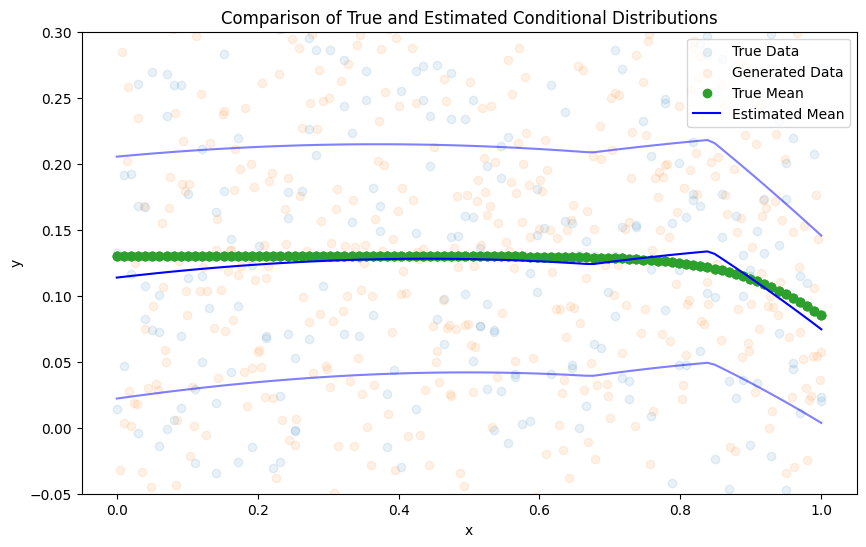

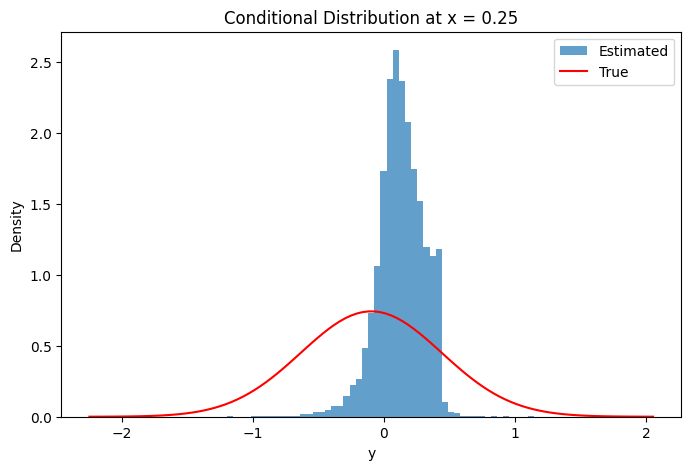

Sample Mean: 0.12866994738578796 | True Mean -0.0965735912322998
Sample Variance: 0.03152190148830414 | True Variance 0.28890625


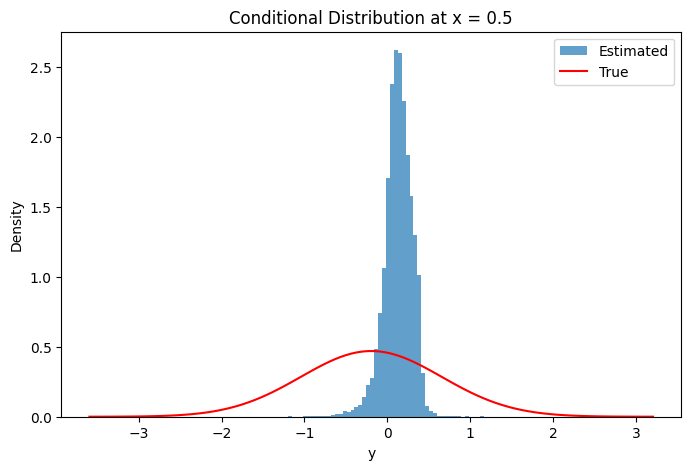

Sample Mean: 0.1305619180202484 | True Mean -0.1931471824645996
Sample Variance: 0.029322152957320213 | True Variance 0.7224999999999999


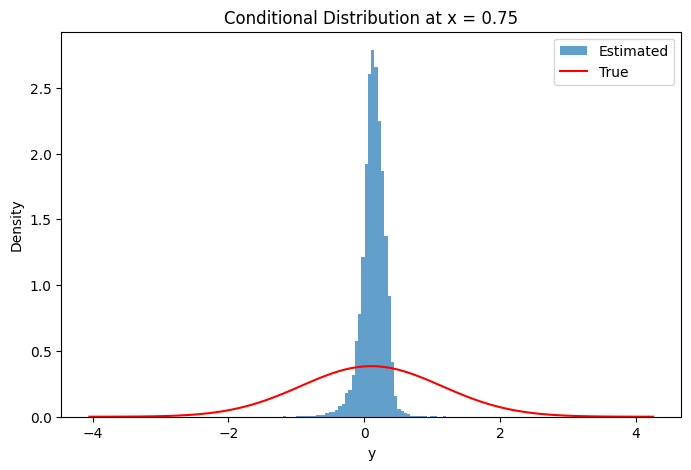

Sample Mean: 0.13137170672416687 | True Mean 0.10271531343460083
Sample Variance: 0.02819007635116577 | True Variance 1.0764062500000002


In [210]:
# Generate samples from the learned distribution
L = 1
x_test = jnp.linspace(0, L, 500).reshape(-1, 1)
z = jax.random.normal(jax.random.PRNGKey(2), (500, 1))
estimated_samples, _ = model.forward(z, x_test)

x_means = jnp.linspace(0, L, 100).reshape(-1, 1)
means = []
stds = []

for x in x_means:
    result = model.forward(z, jnp.array([x]))[0]
    means += result.mean(),
    stds += result.std(),

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, alpha=0.1, label='True Data')
plt.scatter(x_test, estimated_samples, alpha=0.1, label='Generated Data')
# plt.plot(x_test, mean_func(x_test), 'r', label='True Mean')
# plt.plot(x_test, mean_func(x_test)+0.5*std_func(x_test), 'r', alpha=0.5)
# plt.plot(x_test, mean_func(x_test)-0.5*std_func(x_test), 'r', alpha=0.5)

plt.scatter(x_train, means_values, label='True Mean')
plt.plot(x_means, means, 'b', label='Estimated Mean')
plt.plot(x_means, jnp.array(means)+0.5*jnp.array(stds), 'b', alpha=0.5)
plt.plot(x_means, jnp.array(means)-0.5*jnp.array(stds), 'b', alpha=0.5)
plt.legend()
plt.ylim([-0.05, 0.3])
plt.title('Comparison of True and Estimated Conditional Distributions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Conditional distribution at specific x values
x_values = [0.25, 0.5, 0.75]
for x_val in x_values:
    x_cond = jnp.full((10000, 1), x_val)
    z = jax.random.normal(jax.random.PRNGKey(3), (10000, 1))
    samples, _ = model.forward(z, x_cond)
    
    plt.figure(figsize=(8, 5))
    plt.hist(samples, bins=50, density=True, alpha=0.7, label='Estimated')
    true_mean = mean_func(x_val)
    true_dist = stats.norm(true_mean, std_func(x_val))
    x_range = jnp.linspace(true_mean - 4*std_func(x_val), true_mean + 4*std_func(x_val), 100)
    plt.plot(x_range, true_dist.pdf(x_range), 'r', label='True')
    plt.title(f'Conditional Distribution at x = {x_val}')
    plt.xlabel('y')
    plt.ylabel('Density')
    
    plt.legend()
    plt.show()
    print(f'Sample Mean: {samples.mean()} | True Mean {true_mean}')
    print(f'Sample Variance: {samples.var()} | True Variance {std_func(x_val)**2}')

Epoch 0, Shallow Loss: 11.12370777130127, Deep Loss: 8.989646911621094
Epoch 100, Shallow Loss: 1.9946115016937256, Deep Loss: 7.707029819488525
Epoch 200, Shallow Loss: 0.7400239109992981, Deep Loss: 1.7167882919311523
Epoch 300, Shallow Loss: 0.5946152806282043, Deep Loss: 1.5653774738311768
Epoch 400, Shallow Loss: 0.27166876196861267, Deep Loss: 1.6183595657348633
Epoch 500, Shallow Loss: 0.04794076830148697, Deep Loss: 0.7980645895004272
Epoch 600, Shallow Loss: 0.03436703234910965, Deep Loss: 0.9745460748672485
Epoch 700, Shallow Loss: 0.00855884701013565, Deep Loss: 0.6766650676727295
Epoch 800, Shallow Loss: 0.007166026160120964, Deep Loss: 0.7246271371841431
Epoch 900, Shallow Loss: 0.005713759455829859, Deep Loss: 0.7068973779678345


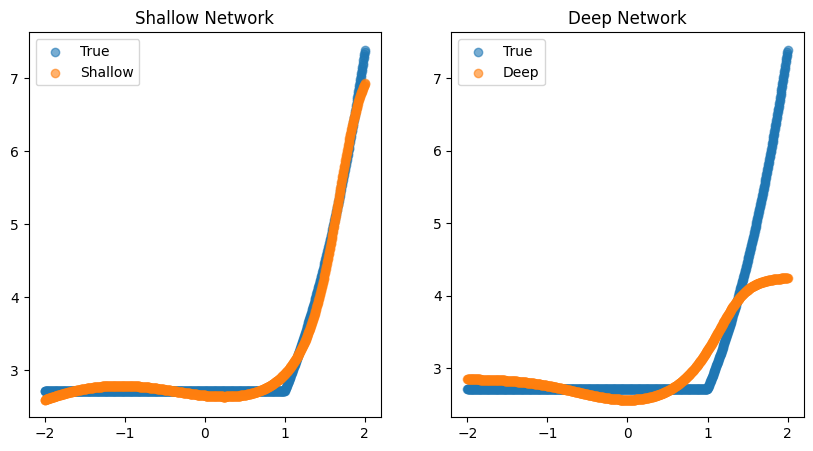

In [115]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import numpy as np


def ff(x):
    return jnp.where(x < 1, jnp.exp(1), jnp.exp(x))
    
# Generate synthetic data
x = np.linspace(-2, 2, 1000).reshape(-1, 1)
y = ff(x)

x = x_train
y = means_values

# Convert to JAX arrays
x = jnp.array(x)
y = jnp.array(y)

# Define the MLP models
class MLP(eqx.Module):
    layers: list
    output: eqx.nn.Linear

    def __init__(self, layer_sizes, key):
        keys = jax.random.split(key, len(layer_sizes))
        self.layers = [eqx.nn.Linear(layer_sizes[i], layer_sizes[i + 1], key=keys[i]) for i in range(len(layer_sizes) - 1)]
        self.output = eqx.nn.Linear(layer_sizes[-1], 1, key=keys[-1])

    def __call__(self, x):
        for layer in self.layers:
            x = jax.nn.tanh(layer(x))
        x = self.output(x)
        return x

# Define loss function and optimizer
def mse_loss(model, x, y):
    pred = jax.vmap(model)(x)
    return jnp.mean((pred - y) ** 2)

@jax.jit
def update(model, x, y, opt_state):
    loss, grads = jax.value_and_grad(mse_loss)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# Set up models
key = jax.random.PRNGKey(0)
shallow_model = MLP([1, 32, 32, 32], key)
deep_model = MLP([1, 6, 6, 6, 6, 6, 6], key)

# Set up optimizer
learning_rate = 0.001
optimizer = optax.adam(learning_rate)
shallow_opt_state = optimizer.init(shallow_model)
deep_opt_state = optimizer.init(deep_model)

# Training loop
epochs = 1000
batch_size = 32

for epoch in range(epochs):
    indices = np.random.choice(len(x), batch_size, replace=False)
    x_batch = x[indices]
    y_batch = y[indices]

    shallow_model, shallow_opt_state, shallow_loss = update(shallow_model, x_batch, y_batch, shallow_opt_state)
    deep_model, deep_opt_state, deep_loss = update(deep_model, x_batch, y_batch, deep_opt_state)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Shallow Loss: {shallow_loss}, Deep Loss: {deep_loss}")

# Prediction
shallow_predictions = jax.vmap(shallow_model)(x)
deep_predictions = jax.vmap(deep_model)(x)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(x, y, label='True', alpha=0.6)
plt.scatter(x, shallow_predictions, label='Shallow', alpha=0.6)
plt.title('Shallow Network')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(x, y, label='True', alpha=0.6)
plt.scatter(x, deep_predictions, label='Deep', alpha=0.6)
plt.title('Deep Network')
plt.legend()

plt.show()
